In [1]:
# from spectral import *
import spectral.io.envi as envi
import h5py
import numpy as np
import matplotlib.pyplot as plt
# import hyperspy.api as hs
import pandas as pd

# Import hrHSI file

In [2]:
def LoadHSI(path_to_hdf5, return_wlens = False, print_info = False):

    # Open the HDF5 file
    with h5py.File(path_to_hdf5, 'r') as f:
        if print_info:

            # List the names of all datasets in the file
            print("Datasets in the file:")

            for name in f.keys():
                print(name)

                # List the attributes of the dataset
                data = f[name]
                print("Attributes of the dataset:")

                for key in data.attrs.keys():
                    print(f"{key}: {data.attrs[key]}")


        # get the dataset from the file (this is how we save the objects downstairs)
        dataset = f['hypercube']
        hcube = f['hypercube'][:]

        if not return_wlens:
            return hcube
        else:
            return hcube, np.array(dataset.attrs['wavelength_nm'])

In [3]:
hr_path = "data/FX10/"
hr_file = LoadHSI(hr_path + "leaf_test1.hdf5", return_wlens=True, print_info=False)

# Load hypercube
hr_img = hr_file[0]

# Normalize hypercube
hr_img = hr_img / np.max(hr_img)

# Flip hypercube to align with snapshot
hr_img = np.flip(hr_img, axis=1)
hr_img = np.flip(hr_img, axis=2)

# Rearrange hypercube to be in the shape of (x, y, wavelength)
hr_img = np.moveaxis(hr_img, 0, -1)

# Load wavelengths as integers
hr_wavelengths = hr_file[1].astype(int)
hr_wavelengths = hr_wavelengths.tolist()

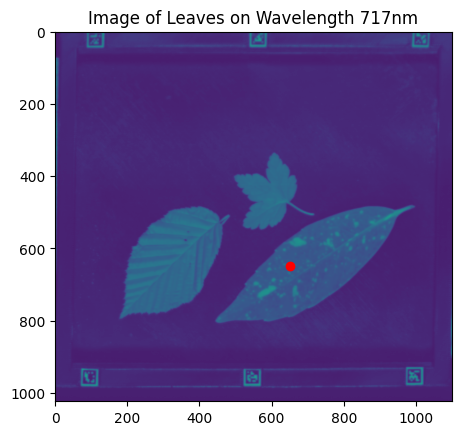

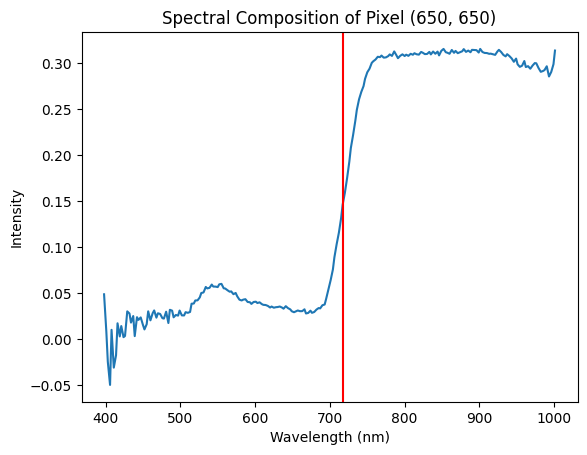

In [39]:
# Select a pixel on a leaf
hr_selected_pixel = (650, 650)
hr_selected_spectrum = 120

# Print array as image
plt.figure()
plt.imshow(hr_img[:, :, hr_selected_spectrum])
plt.plot(hr_selected_pixel[0], hr_selected_pixel[1], 'ro')
plt.title('Image of Leaves on Wavelength ' + str(hr_wavelengths[hr_selected_spectrum]) + 'nm')
plt.show()


# Print spectral composition of a single pixel
hr_spectrum = hr_img[hr_selected_pixel[0], hr_selected_pixel[1], :]

# Plot the spectrum
plt.figure()
plt.plot(hr_wavelengths, hr_spectrum)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.title('Spectral Composition of Pixel ' + str(hr_selected_pixel))
plt.axvline(hr_wavelengths[hr_selected_spectrum], color='r', linestyle='-')
plt.show()

## Extracting needed data from the image

In [41]:
# Get the intensity on the selected pixel on the selected wavelength
print('Intensity of selected pixel on selected wavelength:', hr_spectrum[hr_selected_spectrum])

Intensity of selected pixel on selected wavelength: 0.14611582815866175


## Load Snapshot file

In [44]:
ss_path = "data/Snapshot/leaf_test_processed/leaf_test/"

# Open image
ss_file = envi.open(ss_path + "image_0000000000.hdr", ss_path + "image_0000000000.raw")

# Load as ImageArray
ss_img = ss_file.load()

# Load as numpy array
ss_img_np = np.array(ss_file.load())

# Normalize image
ss_img_np = ss_img_np / np.max(ss_img_np)

# Load wavelengths
ss_wavelengths = ss_file.metadata['wavelength']
ss_wavelengths = [float(wavelength) for wavelength in ss_wavelengths]

# Turn float to int
ss_wavelengths = [int(wavelength) for wavelength in ss_wavelengths]

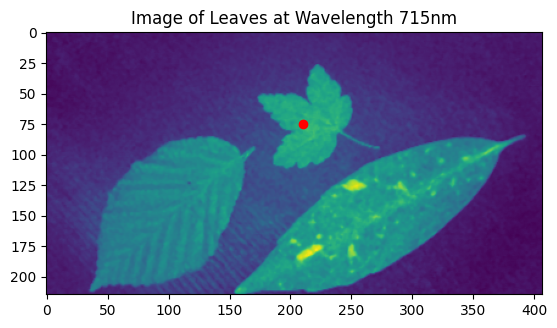

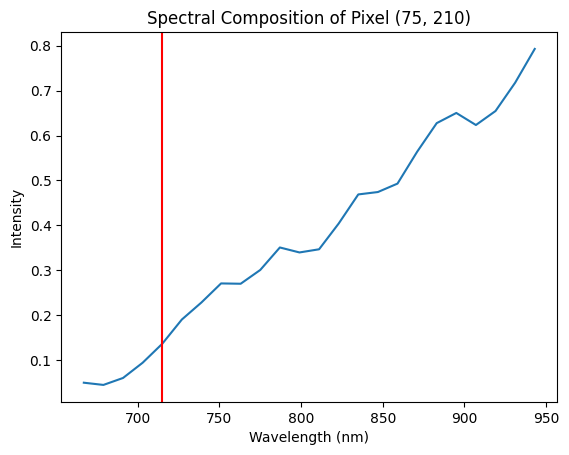

In [45]:
# Select a pixel on a leaf
ss_selected_pixel = (75, 210)
ss_selected_spectrum = 4

# Print array as image
plt.figure()
plt.imshow(ss_img_np[:, :, ss_selected_spectrum])
plt.plot(ss_selected_pixel[1], ss_selected_pixel[0], 'ro')
plt.title('Image of Leaves at Wavelength ' + str(ss_wavelengths[ss_selected_spectrum]) + 'nm')
plt.show()

# Print spectral composition of a single pixel
ss_spectrum = ss_img_np[ss_selected_pixel[0], ss_selected_pixel[1]]

# Plot the spectrum
plt.figure()
plt.plot(ss_wavelengths, ss_spectrum)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.title('Spectral Composition of Pixel ' + str(ss_selected_pixel))
plt.axvline(ss_wavelengths[ss_selected_spectrum], color='r', linestyle='-')
plt.show()

# Compare hrHSI and Snapshot

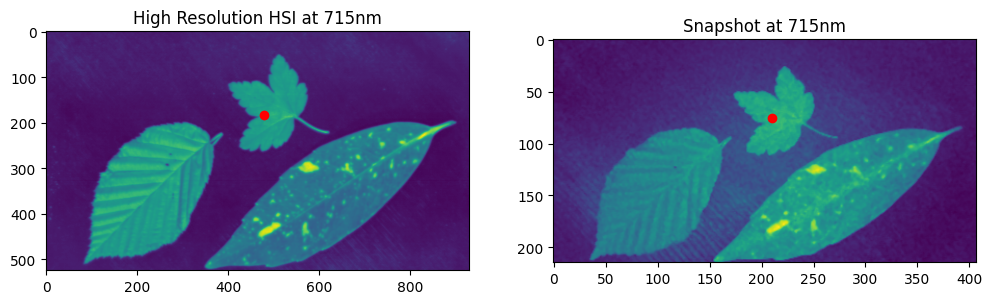

In [82]:
selected_pixel = (75, 210)
selected_spectrum = 715

# Pick closest value to selected spectrum in list of wavelengths
hr_selected_spectrum_index = hr_wavelengths.index(min(hr_wavelengths, key=lambda x:abs(x-selected_spectrum)))
ss_selected_spectrum_index = ss_wavelengths.index(min(ss_wavelengths, key=lambda x:abs(x-selected_spectrum)))

# Crop hrHSI to match snapshot
y_off = (285, 810)
x_off = (95, 1024)
hr_img_cropped = hr_img[y_off[0]:y_off[1], x_off[0]:x_off[1], :]

# Transform selected pixel to scale
scaling = (hr_img_cropped.shape[0] / ss_img_np.shape[0], hr_img_cropped.shape[1] / ss_img_np.shape[1])
selected_pixel_scaled = (selected_pixel[0]*scaling[0], selected_pixel[1]*scaling[1])

# Print hrHSI and snapshot image next to each other
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(hr_img_cropped[:, :, hr_selected_spectrum_index])
plt.plot(selected_pixel_scaled[1], selected_pixel_scaled[0], 'ro')
plt.title('High Resolution HSI' + ' at ' + str(hr_wavelengths[hr_selected_spectrum_index]) + 'nm')
plt.subplot(1, 2, 2)
plt.imshow(ss_img_np[:, :, ss_selected_spectrum_index])
plt.plot(selected_pixel[1], selected_pixel[0], 'ro')
plt.title('Snapshot' + ' at ' + str(ss_wavelengths[ss_selected_spectrum_index]) + 'nm')
plt.show()


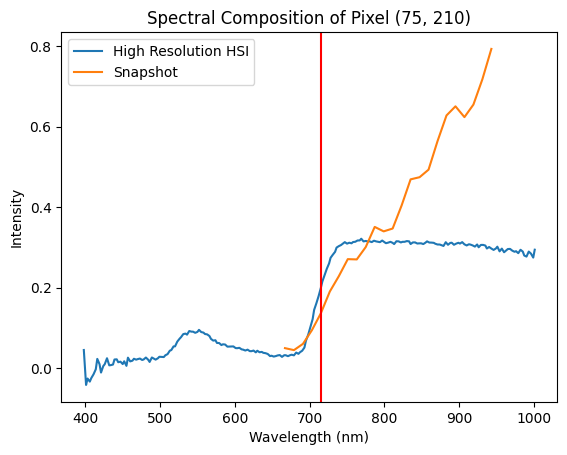

In [83]:
# Compare the spectral composition of the selected pixel in both images
plt.figure()
plt.plot(hr_wavelengths, hr_img_cropped[int(selected_pixel_scaled[0]), int(selected_pixel_scaled[1]), :])
plt.plot(ss_wavelengths, ss_img_np[selected_pixel[0], selected_pixel[1], :])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.title('Spectral Composition of Pixel ' + str(selected_pixel))
plt.legend(['High Resolution HSI', 'Snapshot'])
plt.axvline(selected_spectrum, color='r', linestyle='-')
plt.show()
